# Measure the Gain of the New 90Prime CCDs
Griffin Hosseinzadeh (2023 February 7)

## Following these instructions

* http://spiff.rit.edu/classes/phys445/lectures/gain/gain.html

* https://www.mirametrics.com/tech_note_ccdgain.php

In [1]:
from astropy.io import fits
from astropy.visualization import imshow_norm, ZScaleInterval
import matplotlib.pyplot as plt
import numpy as np
from glob import glob

In [2]:
filenames = sorted(glob('/Users/griffin/Downloads/flats/*.fits'))
hdulists = [fits.open(fn) for fn in filenames]
exptimes = [hdulist[0].header.get('exptime') for hdulist in hdulists]

Amp 1: Gain = 2.94 e-/ADU, Read Noise = 60.4 e-
Amp 2: Gain = 2.89 e-/ADU, Read Noise = 61.1 e-
Amp 3: Gain = 2.93 e-/ADU, Read Noise = 63.4 e-
Amp 4: Gain = 2.86 e-/ADU, Read Noise = 65.5 e-
Amp 5: Gain = 2.93 e-/ADU, Read Noise = 57.1 e-
Amp 6: Gain = 2.92 e-/ADU, Read Noise = 69.9 e-
Amp 7: Gain = 2.86 e-/ADU, Read Noise = 76.9 e-
Amp 8: Gain = 2.86 e-/ADU, Read Noise = 302.3 e-


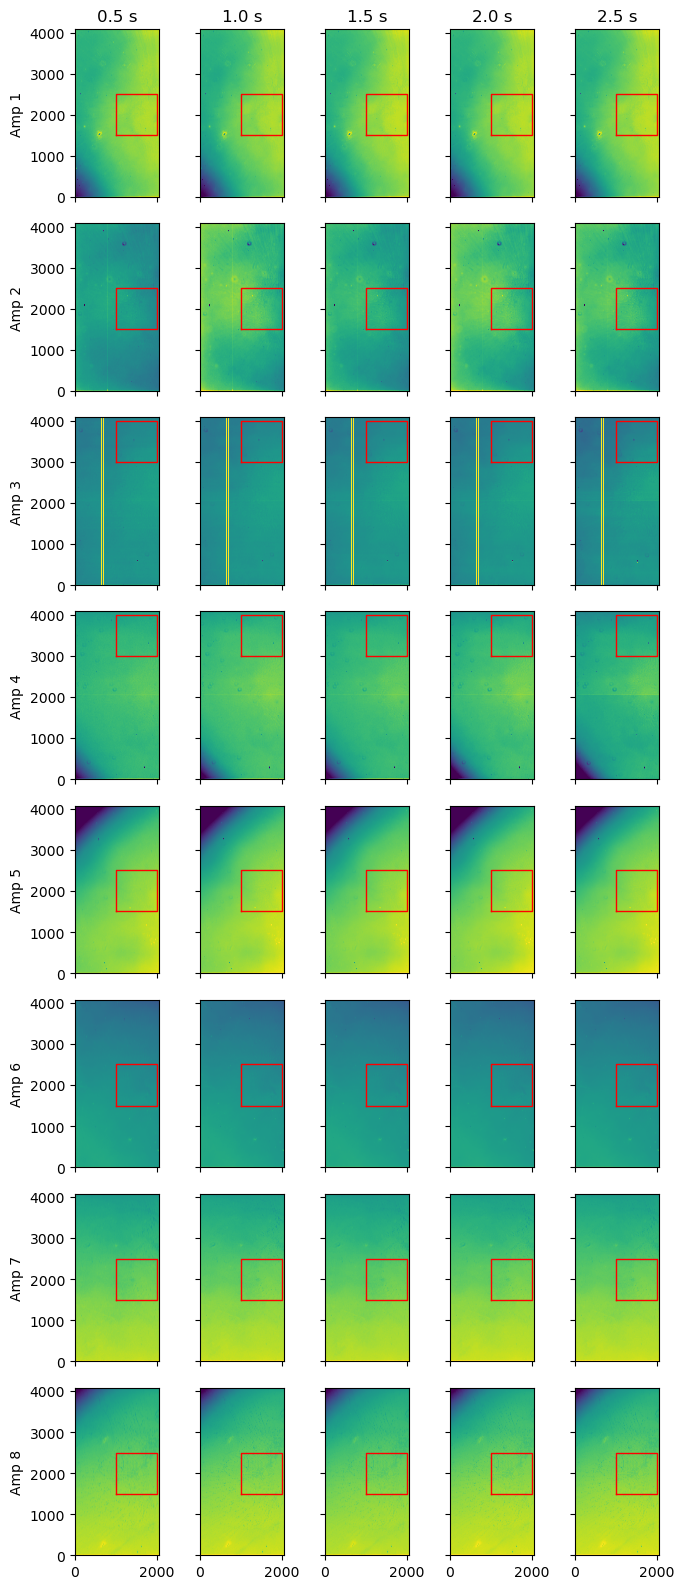

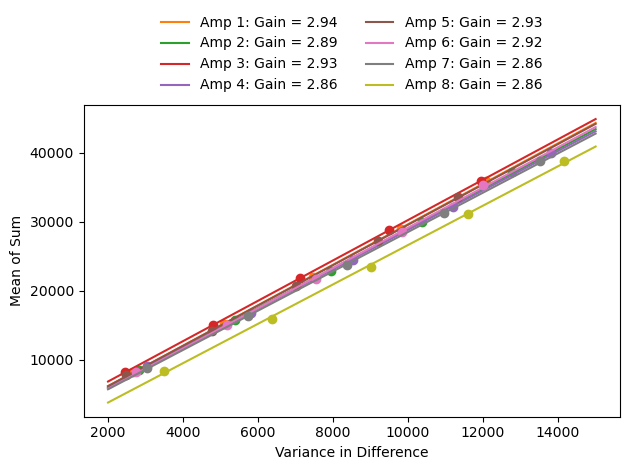

In [3]:
fig, axes = plt.subplots(8, 5, sharex=True, sharey=True, figsize=(7., 16.))
fig2, ax2 = plt.subplots()

gains = []
for amp in range(1, 9):
    ampdata = np.array([hdulist[amp].data for hdulist in hdulists], float)

    # choose the region used to calculate the gain
    xslice = slice(1000, 2000)
    if amp in [3, 4]:  # avoid an artifact near the middle of the chip
        yslice = slice(3000, 4000)
    else:
        yslice = slice(1500, 2500)
    gaindata = ampdata[:, yslice, xslice]
    
    summeans = []
    diffvars = []
    for exp, ax in zip(range(0, len(ampdata), 5), axes[amp - 1]):  # we took 5 images at each exposure time
        # make the plots to make sure we're choosing a good region
        imshow_norm(ampdata[exp], ax=ax, interval=ZScaleInterval(), origin='lower')
        ax.plot([xslice.start, xslice.stop, xslice.stop, xslice.start, xslice.start],
                [yslice.start, yslice.start, yslice.stop, yslice.stop, yslice.start], 'r', lw=1)
        if amp == 1:
            ax.set_title(f'{exptimes[exp]:.1f} s')
        if exp == 0:
            ax.set_ylabel(f'Amp {amp:d}')
        
        # measure the statistics
        summeans.append(np.sum(gaindata[exp:exp+2], axis=0).mean() / 2.)
        diffvars.append(np.diff(gaindata[exp:exp+2], axis=0).var() / 2.)
    
    # fit for the gain (slope)
    g, rn = np.polyfit(diffvars, summeans, 1)
    gains.append(g)
    xfit = np.array([2000., 15000.])
    yfit = rn + g * xfit
    
    # make the gain plot
    ax2.plot(diffvars, summeans, marker='o', ls='none', color=f'C{amp:d}')
    ax2.plot(xfit, yfit, label=f'Amp {amp:d}: Gain = {g:.2f}', color=f'C{amp:d}')
    
    # calculate the read noise from the overscan region
    biassecx, biassecy = hdulists[0][amp].header['BIASSEC'][1:-1].split(',')
    biasx = slice(*eval(biassecx.replace(':', ',')))
    biasy = slice(*eval(biassecy.replace(':', ',')))
    biasdata = hdulists[0][amp].data[biasy, biasx]
    print(f'Amp {amp:d}: Gain = {g:.2f} e-/ADU, Read Noise = {biasdata.std() * g:.1f} e-')

ax2.set_xlabel('Variance in Difference')
ax2.set_ylabel('Mean of Sum')
ax2.legend(loc='lower center', bbox_to_anchor=(0.5, 1.), ncol=2, frameon=False)
fig2.tight_layout()

fig.tight_layout()

In [4]:
# in case the overscan region in the flats is bad, use the overscan from a bias
hdulist0 = fits.open('/Users/griffin/Downloads/a.ZERO.0276.fits')
for amp, g in enumerate(gains, start=1):
    biassecx, biassecy = hdulist0[amp].header['BIASSEC'][1:-1].split(',')
    biasx = slice(*eval(biassecx.replace(':', ',')))
    biasy = slice(*eval(biassecy.replace(':', ',')))
    biasdata = hdulist0[amp].data[biasy, biasx]
    print(f'Amp {amp:d}: Gain = {g:.2f} e-/ADU, Read Noise = {biasdata.std() * g:.1f} e-')

Amp 1: Gain = 2.94 e-/ADU, Read Noise = 5.6 e-
Amp 2: Gain = 2.89 e-/ADU, Read Noise = 5.0 e-
Amp 3: Gain = 2.93 e-/ADU, Read Noise = 8.4 e-
Amp 4: Gain = 2.86 e-/ADU, Read Noise = 5.1 e-
Amp 5: Gain = 2.93 e-/ADU, Read Noise = 5.0 e-
Amp 6: Gain = 2.92 e-/ADU, Read Noise = 13.3 e-
Amp 7: Gain = 2.86 e-/ADU, Read Noise = 4.8 e-
Amp 8: Gain = 2.86 e-/ADU, Read Noise = 5.8 e-
